In [1]:
# import pkg_resources
import logging
import shutil
import warnings

import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
from darts import TimeSeries, concatenate
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, mape, mse  # smape
from darts.models import TFTModel, TiDEModel
from darts.utils.callbacks import TFMProgressBar
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from lightning.pytorch import Trainer
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from scipy.optimize import minimize

# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange

# from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


class OptunaPruning(PyTorchLightningPruningCallback, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


# set a consant figure size
plt.rcParams["figure.figsize"] = (32, 5)  # set default size of plots
fig_size = (32, 5)  # wide figures

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch23/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%load_ext autoreload 
# Reload all modules every time before executing the Python code typed.
%autoreload 2 
# Visualizations will be displayed in the notebook.
%matplotlib inline

In [3]:
# Load the data
df = pd.read_csv(
    "data/df_blood_preprocessed.csv",
)
# Convert 'ds' and 'first_infusion_date' to datetime
df["ds"] = pd.to_datetime(df["ds"], format="%Y-%m-%d %H:%M:%S")
df["first_infusion_date"] = pd.to_datetime(df["first_infusion_date"], format="%Y-%m-%d")
df["next_infusion"] = pd.to_datetime(df["next_infusion"], format="%Y-%m-%d")
dtype_map = {
    "ds": "datetime64[ns]",
    "first_infusion_date": "datetime64[ns]",
    "next_infusion": "datetime64[ns]",
    "unique_id": int,
    "sex": int,
    "age_at_diagdate": float,
    "weight_change_cycles": float,
    "component": str,
    "value": float,
    "unit": str,
    "days_since_first_infusion": int,
    "infno_day": int,
    "infno": int,
}
df = df.astype(dtype_map)

In [4]:
# Print the number of unique patients in the DataFrame
num_unique_patients = df["unique_id"].nunique()
print(f"Number of unique patients: {num_unique_patients}")

Number of unique patients: 182


In [5]:
# For now remove the last data point for each component for each patient
# The patients last values are often high as they have recovered from the treatment
# and are perhaps not representative of the general trend
# df = (
#     df.groupby(["unique_id", "component"])
#     .apply(lambda x: x.iloc[:-2])
#     .reset_index(drop=True)
# )

In [6]:
def anonymize_unique_id(df):
    # Create a mapping dictionary to replace digits with letters
    digit_to_letter = {str(i): chr(ord("a") + i - 1) for i in range(1, 10)}
    digit_to_letter["0"] = "j"

    # Apply the mapping to the 'unique_id' column
    df["unique_id"] = (
        df["unique_id"]
        .astype(str)
        .apply(lambda x: "".join(digit_to_letter[d] for d in x))
    )

    return df


df = anonymize_unique_id(df)

In [7]:
print(df.columns)

Index(['ds', 'first_infusion_date', 'next_infusion', 'unique_id', 'sex',
       'age_at_diagdate', 'weight_change_cycles', 'transer', 'transth',
       'component', 'value', 'unit', 'days_since_first_infusion', 'infno',
       'infno_day'],
      dtype='object')


In [8]:
# Drop the original columns, we will recreate the infusion day "infno_day" 
# which is a numeric representation of the day after each infusion
# 
#  and unit columns later
df = df.drop(columns=["unit", "infno_day", "transer", "transth"])

component_list = df["component"].unique()

In [9]:
print(df.columns)

Index(['ds', 'first_infusion_date', 'next_infusion', 'unique_id', 'sex',
       'age_at_diagdate', 'weight_change_cycles', 'component', 'value',
       'days_since_first_infusion', 'infno'],
      dtype='object')


In [10]:
class TimeSeriesPreprocessor:
    def __init__(
        self,
        target_column=None,
        complete_timeline=False,
        encode_temporal_distance=False,
        add_decay=False,
        fill_residual_nan=False,
        exclude_columns=None,
    ):
        self.target_column = target_column
        self.complete_timeline = complete_timeline
        self.encode_temporal_distance = encode_temporal_distance
        self.add_decay = add_decay
        self.decay_models = {}
        self.fill_residual_nan = fill_residual_nan
        self.exclude_columns = exclude_columns or []

    def _aggregate_daily(self, X):
        X["ds_date"] = X["ds"].dt.date
        grouped = X.groupby(
            ["unique_id", "ds_date", "age_at_diagdate", "sex", "infno", "component"]
        )
        daily_data = grouped.agg({"value": "mean"}).reset_index()
        return daily_data

    def _initial_preparation(self, X):
        X = self._aggregate_daily(X)
        X["ds_date"] = pd.to_datetime(X["ds_date"])
        X["normalized_time_days"] = X.groupby("unique_id")["ds_date"].transform(
            lambda x: (x - x.min()).dt.days
        )
        X["normalized_time"] = X.groupby("unique_id")["normalized_time_days"].transform(
            lambda x: x - x.min()
        )

        X = X.pivot_table(
            index=[
                "unique_id",
                "normalized_time",
                "age_at_diagdate",
                "sex",
                "infno",
                "ds_date",
            ],
            columns="component",
            values="value",
            aggfunc="first",
        ).reset_index()

        if self.target_column is not None and self.target_column not in X.columns:
            raise ValueError(
                f"Target column '{self.target_column}' not found in DataFrame."
            )
        else:
            X = X.rename(columns={self.target_column: "y"})
        return X

    def _calculate_infno_day(self, df):
        df["infno_first_time"] = df.groupby(["unique_id", "infno"])[
            "normalized_time"
        ].transform("min")
        df.insert(
            df.columns.get_loc("infno") + 1,
            "infno_day",
            df["normalized_time"] - df["infno_first_time"],
        )
        df.drop(columns=["infno_first_time", "ds_date"], inplace=True)
        return df

    def prepare_and_process(self, X):
        df = self._initial_preparation(X)

        if self.complete_timeline:
            df = self._complete_timeline(df)

        df = self._calculate_infno_day(df)

        if self.encode_temporal_distance or self.add_decay:
            df = self._simple_missingness_encoding(df)
            df = self._encode_temporal_distance(df)

        if self.add_decay:
            self._estimate_decay_parameters(df)
            df = self._apply_decay(df)

        if self.fill_residual_nan:
            df = self._fill_residual_nan(df)

        return df

    def _complete_timeline(self, df):
        unique_ids = df["unique_id"].unique()
        complete_timeline = []

        for uid in unique_ids:
            uid_df = df[df["unique_id"] == uid]
            min_time = uid_df["normalized_time"].min()
            max_time = uid_df["normalized_time"].max()

            timeline = pd.DataFrame(
                {"unique_id": uid, "normalized_time": np.arange(min_time, max_time + 1)}
            )
            complete_timeline.append(timeline)

        complete_timeline = pd.concat(complete_timeline, ignore_index=True)

        df = pd.merge(
            complete_timeline, df, on=["unique_id", "normalized_time"], how="left"
        )
        static_columns = ["unique_id", "age_at_diagdate", "sex"]
        for col in static_columns:
            df[col] = df.groupby("unique_id")[col].ffill().bfill()

        dynamic_columns = ["infno"]
        for col in dynamic_columns:
            df[col] = df.groupby("unique_id")[col].ffill()

        return df

    def _simple_missingness_encoding(self, df):
        missingness_indicators = (
            df.loc[:, ~df.columns.isin(self.exclude_columns)].isna().astype(int)
        )
        missingness_indicators = missingness_indicators.add_suffix("_missing")
        df = pd.concat([df, missingness_indicators], axis=1)
        return df

    def _encode_temporal_distance(self, df):
        feature_columns = [
            col
            for col in df.columns
            if col not in self.exclude_columns and not col.endswith("_missing")
        ]
        temporal_distance_data = {}
        for col in feature_columns:
            if not col.endswith("_delta"):
                # Calculate temporal distance
                temporal_distance_series = (
                    df.groupby("unique_id")[col]
                    .apply(
                        lambda x: x.isna()
                        .astype(int)
                        .groupby(x.notna().astype(int).cumsum())
                        .cumsum()
                    )
                    .astype(float)
                )  # Ensure the dtype is consistent (e.g., float)
                temporal_distance_data[col + "_delta"] = temporal_distance_series

        # Convert dictionary values to series with consistent dtype
        for key in temporal_distance_data:
            temporal_distance_data[key] = temporal_distance_data[key].astype(float)

        temporal_distance_df = pd.DataFrame(temporal_distance_data)
        temporal_distance_df = temporal_distance_df.set_index(df.index)

        df = pd.concat([df, temporal_distance_df], axis=1)
        return df

    def _estimate_decay_parameters(self, df):
        decay_params = {}
        for feature in [
            col
            for col in df.columns
            if not col.endswith(("_delta", "_missing"))
            and col not in self.exclude_columns
        ]:
            df[feature + "_last"] = df.groupby("unique_id")[feature].ffill()
            feature_df = df[[feature + "_delta", feature, feature + "_last"]].dropna()
            X_train = feature_df[feature + "_delta"].values
            y_train = feature_df[feature].values
            y_last = feature_df[feature + "_last"].values
            X_train_normalized = (X_train - X_train.min()) / (
                X_train.max() - X_train.min()
            )

            def objective(params):
                W, b = params
                decay_factor = np.exp(-np.maximum(0, W * X_train_normalized + b))
                loss = np.mean(np.abs(y_train - (y_last * decay_factor)))
                return loss

            initial_params = [0.0, 0.0]
            methods = ["L-BFGS-B", "TNC", "SLSQP"]
            best_result = None
            best_loss = float("inf")
            best_method = None
            for method in methods:
                try:
                    result = minimize(
                        objective,
                        initial_params,
                        method=method,
                        bounds=[(0, None), (None, None)],
                    )
                    if result.success and result.fun < best_loss:
                        best_result = result
                        best_loss = result.fun
                        best_method = method
                except Exception as e:
                    print(
                        f"Optimization failed for feature '{feature}' with method '{method}': {str(e)}"
                    )
            if best_result is not None:
                W_opt, b_opt = best_result.x
                decay_params[feature] = {"W": W_opt, "b": b_opt, "method": best_method}
            df.drop(columns=[feature + "_last"], inplace=True)
        self.decay_params = decay_params

    def _apply_decay(self, df):
        df_copy = df.copy()
        last_columns = {}
        for feature in self.decay_params:
            last_columns[feature + "_last"] = df_copy.groupby("unique_id")[
                feature
            ].ffill()
        last_df = pd.DataFrame(last_columns)
        for feature in self.decay_params:
            W, b = self.decay_params[feature]["W"], self.decay_params[feature]["b"]
            decay_factor = np.exp(-np.maximum(0, W * df_copy[feature + "_delta"] + b))
            df_copy[feature] = last_df[feature + "_last"] * decay_factor
            df_copy[feature] = df_copy[feature].fillna(last_df[feature + "_last"])
        df_copy = df_copy.drop(
            columns=[col for col in df_copy if col.endswith("_last")]
        )
        return df_copy

    def _fill_residual_nan(self, df):
        feature_columns = [
            col
            for col in df.columns
            if col not in self.exclude_columns
            and not col.endswith(("_missing", "_delta"))
        ]
        df[feature_columns] = df[feature_columns].interpolate(method="linear")
        df[feature_columns] = df[feature_columns].fillna(method="bfill")
        df[feature_columns] = df[feature_columns].fillna(method="ffill")

        return df


# Example usage:
# Assuming 'df' is your DataFrame and you have set the parameters as needed:
preprocessor = TimeSeriesPreprocessor(
    target_column="Neutrophilocytes_B",
    complete_timeline=True,
    encode_temporal_distance=True,
    add_decay=True,
    fill_residual_nan=True,
    exclude_columns=[
        "unique_id",
        "normalized_time",
        "sex",
        "age_at_diagdate",
        "infno",
        "infno_day",
        "ds_date",
        "infno_first_time",
    ],
)

# Assuming 'df' is your DataFrame
processed_df = preprocessor.prepare_and_process(df)
print(processed_df.shape)
processed_df.head(50)

(71825, 195)


,unique_id,normalized_time,age_at_diagdate,sex,infno,infno_day,Alanine_transaminase_ALAT,Albumin_P,Alkaline_phosphatase_P,Amylase_P,...,Promyelocytes_B_delta,Protein_cerebrospinal_fluid_CSF_delta,Reticulocytes_total_B_delta,Sodium_ion_P_delta,Thrombocytes_B_delta,Thyrotropin_TSH_delta,Triacylglycerol_lipase_delta,Triglycerides_P_pt_fasting_status_unknown_delta,Urate_delta,eGFR_DSKB_DNS_2009_delta
0,bjaaaaa,0,14.0,2.0,1.0,0,238.000000,32.000000,82.000000,40.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,bjaaaaa,1,14.0,2.0,1.0,1,162.000000,31.000000,76.500000,40.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2,bjaaaaa,2,14.0,2.0,1.0,2,140.333333,30.000000,71.000000,40.0,...,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0
3,bjaaaaa,3,14.0,2.0,1.0,3,168.888889,29.666667,78.666667,40.0,...,4.0,4.0,4.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0
4,bjaaaaa,4,14.0,2.0,1.0,4,197.444444,29.333333,86.333333,40.0,...,5.0,5.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0
5,bjaaaaa,5,14.0,2.0,1.0,5,226.000000,29.000000,94.000000,40.0,...,6.0,6.0,6.0,0.0,0.0,6.0,6.0,6.0,6.0,6.0
6,bjaaaaa,6,14.0,2.0,1.0,6,0.000000,29.500000,0.000000,40.0,...,7.0,7.0,7.0,1.0,0.0,7.0,7.0,7.0,7.0,7.0
7,bjaaaaa,7,14.0,2.0,1.0,7,273.000000,30.000000,102.000000,40.0,...,8.0,8.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,8.0
8,bjaaaaa,8,14.0,2.0,1.0,8,246.857143,32.000000,103.714286,40.0,...,9.0,9.0,0.0,0.0,0.0,9.0,9.0,9.0,9.0,9.0
9,bjaaaaa,9,14.0,2.0,1.0,9,220.714286,31.666667,105.428571,40.0,...,10.0,10.0,1.0,0.0,0.0,10.0,10.0,10.0,10.0,10.0


In [11]:
def debug_data(df, message):
    print(message)
    display(df.head())
    print("Time range:", df["normalized_time"].min(), "to", df["normalized_time"].max())


# Example usage in your preprocessing class
debug_data(processed_df, "Data after normalization:")

Data after normalization:


,unique_id,normalized_time,age_at_diagdate,sex,infno,infno_day,Alanine_transaminase_ALAT,Albumin_P,Alkaline_phosphatase_P,Amylase_P,...,Promyelocytes_B_delta,Protein_cerebrospinal_fluid_CSF_delta,Reticulocytes_total_B_delta,Sodium_ion_P_delta,Thrombocytes_B_delta,Thyrotropin_TSH_delta,Triacylglycerol_lipase_delta,Triglycerides_P_pt_fasting_status_unknown_delta,Urate_delta,eGFR_DSKB_DNS_2009_delta
0,bjaaaaa,0,14.0,2.0,1.0,0,238.000000,32.000000,82.000000,40.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,bjaaaaa,1,14.0,2.0,1.0,1,162.000000,31.000000,76.500000,40.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2,bjaaaaa,2,14.0,2.0,1.0,2,140.333333,30.000000,71.000000,40.0,...,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0
3,bjaaaaa,3,14.0,2.0,1.0,3,168.888889,29.666667,78.666667,40.0,...,4.0,4.0,4.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0
4,bjaaaaa,4,14.0,2.0,1.0,4,197.444444,29.333333,86.333333,40.0,...,5.0,5.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0


Time range: 0 to 458


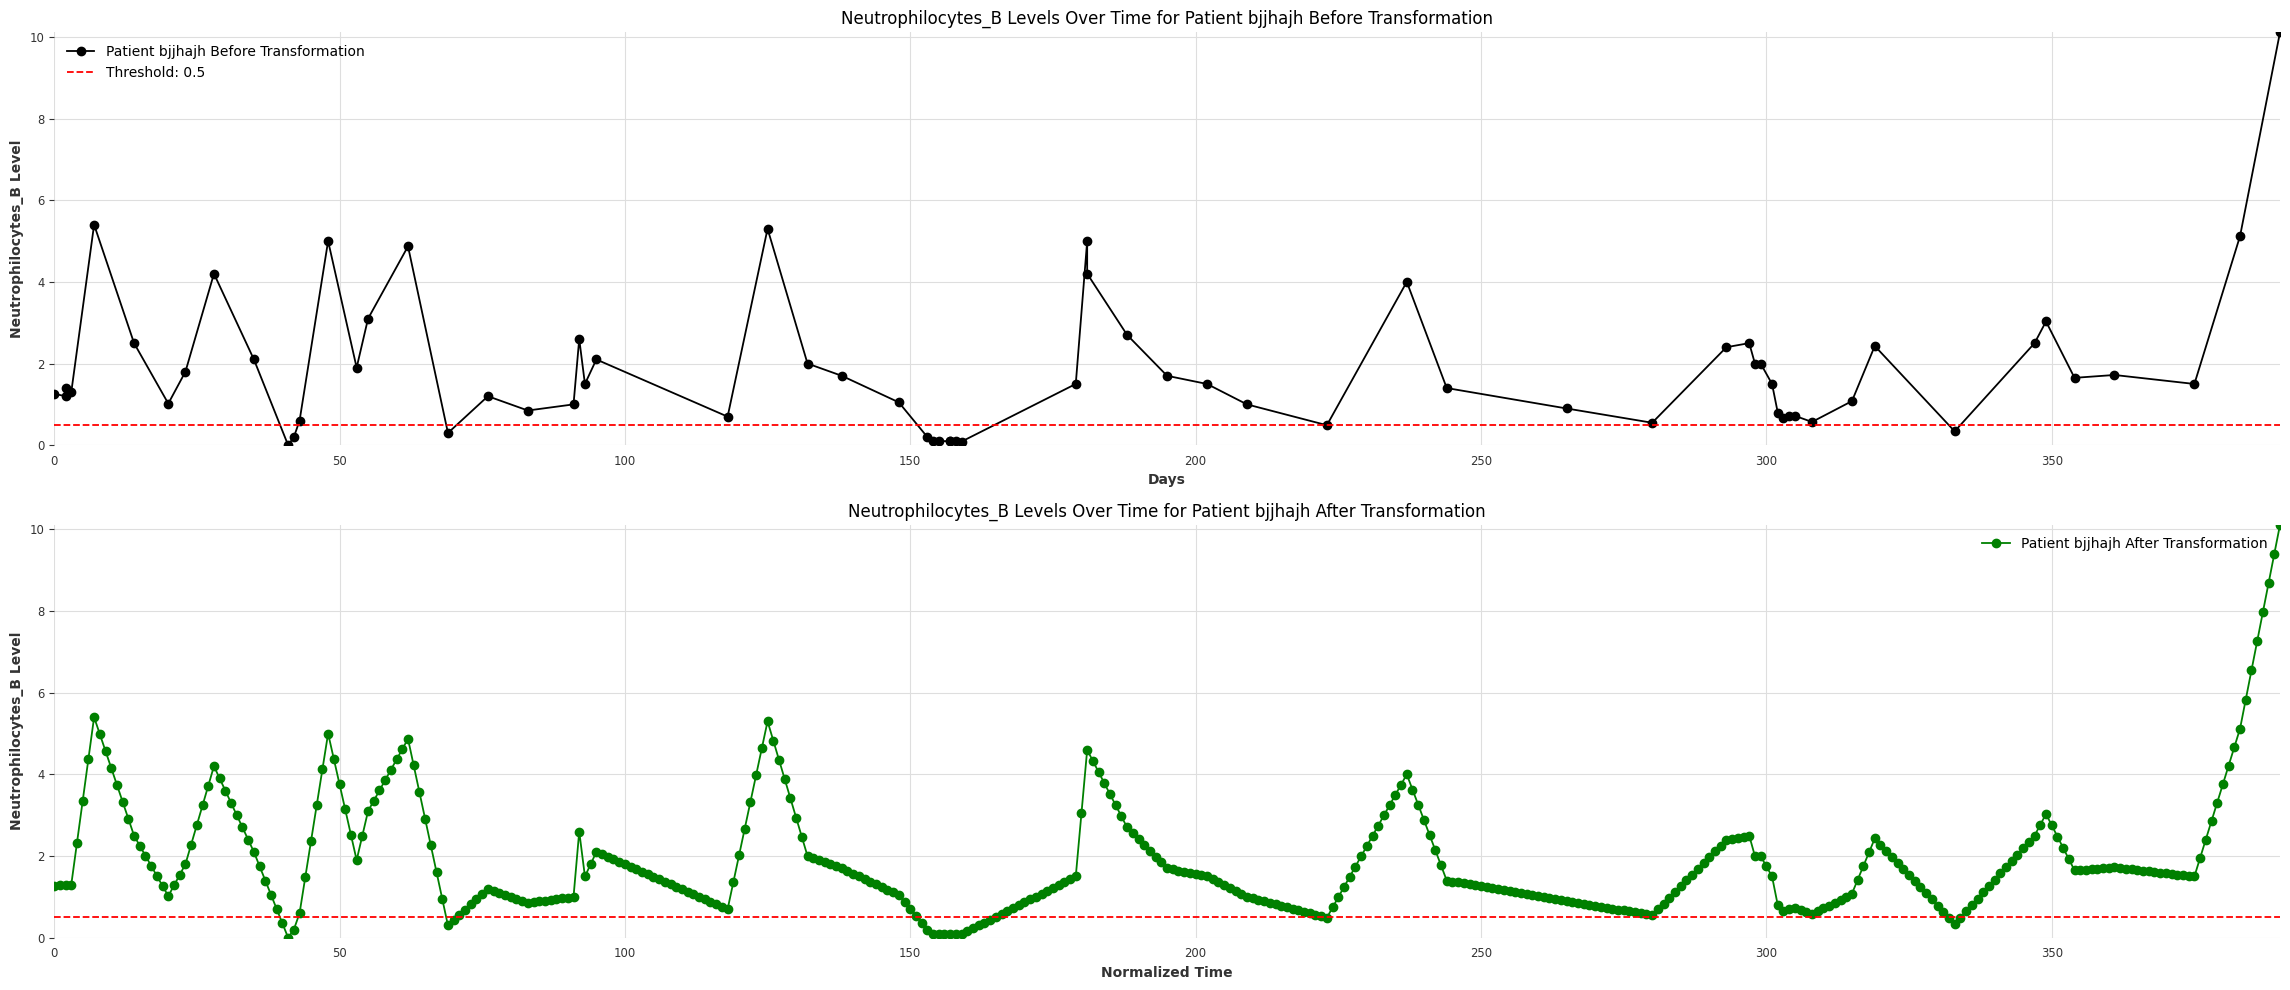

In [12]:
# Replace 'bjjhajh' with the actual unique_id you're interested in
unique_id = "bjjhajh"  # Placeholder, replace with actual integer ID
component_name_before_TimeSeriesPreprocessor = "Neutrophilocytes_B"
component_name_after_TimeSeriesPreprocessor = "y"

# Function to filter patient data before transformation
def filterPatientANC(unique_id, component, df):
    data = df[
        (df["unique_id"] == unique_id) & (df["component"] == component_name_before_TimeSeriesPreprocessor)
    ].sort_values(by="days_since_first_infusion")
    return data


def filterPatientANC_transformed(unique_id, df):
    data = df[(df["unique_id"] == unique_id)]
    # Adjusted to directly use the 'Neutrophilocytes_B' column renamed to 'y' instead of a variable component name
    component_data = data[["normalized_time", component_name_after_TimeSeriesPreprocessor]].dropna()
    return component_data


# Filter data before and after transformation
data_org = filterPatientANC(unique_id, component_name_before_TimeSeriesPreprocessor, df)
data_transformed = filterPatientANC_transformed(unique_id, processed_df)

# Determine the common x and y limits
x_min = min(
    data_org["days_since_first_infusion"].min(),
    data_transformed["normalized_time"].min(),
)
x_max = max(
    data_org["days_since_first_infusion"].max(),
    data_transformed["normalized_time"].max(),
)
y_min = min(data_org["value"].min(), data_transformed[component_name_after_TimeSeriesPreprocessor].min())
y_max = max(data_org["value"].max(), data_transformed[component_name_after_TimeSeriesPreprocessor].max())

# Plotting
plt.figure(figsize=(20, 5))

# Plot before transformation
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(
    data_org["days_since_first_infusion"],
    data_org["value"],
    marker="o",
    linestyle="-",
    label=f"Patient {unique_id} Before Transformation",
)
plt.title(
    f"Neutrophilocytes_B Levels Over Time for Patient {unique_id} Before Transformation"
)
plt.axhline(y=0.5, color="r", linestyle="--", label="Threshold: 0.5")
plt.xlabel("Days")
plt.ylabel("Neutrophilocytes_B Level")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

# Plot after transformation
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(
    data_transformed["normalized_time"],
    data_transformed[component_name_after_TimeSeriesPreprocessor],
    marker="o",
    linestyle="-",
    color="green",
    label=f"Patient {unique_id} After Transformation",
)
plt.title(
    f"Neutrophilocytes_B Levels Over Time for Patient {unique_id} After Transformation"
)
plt.axhline(y=0.5, color="r", linestyle="--")
plt.xlabel("Normalized Time")
plt.ylabel("Neutrophilocytes_B Level")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
def test_decay_application(processed_df, df):
    missing_before = df.isna().sum().sum()
    missing_after = processed_df.isna().sum().sum()

    print(f"Missing values before transformation: {missing_before}")
    print(f"Missing values after transformation: {missing_after}")

    # Assuming decay models should reduce the number of missing values
    if missing_after < missing_before:
        print("Test passed: Decay models applied successfully.")
    else:
        print("Test failed: Decay models may not have been applied correctly.")


test_decay_application(processed_df, df)

Missing values before transformation: 27141
Missing values after transformation: 0
Test passed: Decay models applied successfully.


In [14]:
# Count the number of rows where all columns from the first to the last (excluding the first column) have NaN values
num_rows_all_nan = processed_df.iloc[:, 2:-1].isna().all(axis=1).sum()
print(
    f"Number of rows where all columns from components are NaN values: {num_rows_all_nan}"
)

Number of rows where all columns from components are NaN values: 0


In [15]:
processed_df.shape

(71825, 195)

In [16]:
# calculate the % of nan in each column
nan_percentages = processed_df.isna().mean() * 100
nan_percentages_top10 = nan_percentages.nlargest(10)
print("\nTop 10 columns with highest percentage of NaNs:")
print(nan_percentages_top10)


Top 10 columns with highest percentage of NaNs:
unique_id                    0.0
normalized_time              0.0
age_at_diagdate              0.0
sex                          0.0
infno                        0.0
infno_day                    0.0
Alanine_transaminase_ALAT    0.0
Albumin_P                    0.0
Alkaline_phosphatase_P       0.0
Amylase_P                    0.0
dtype: float64


In [17]:
# Check if any columns with name in component_names have all 0 or non-unique values for each unique_id


def check_dataframe_errors(df):
    # Check for any infinite values
    if df.isin([np.inf, -np.inf]).any().any():
        print("Error: DataFrame contains infinite values.")
    else:
        print("No infinite values found in DataFrame.")

    # Check for any duplicate rows
    if df.duplicated().any():
        print("Error: DataFrame contains duplicate rows.")
    else:
        print("No duplicate rows found in DataFrame.")

    # Check for any columns with constant values (where min equals max)
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]
    if len(constant_columns) > 0:
        print(f"Error: DataFrame contains constant columns: {constant_columns}")
    else:
        print("No constant columns found in DataFrame.")


# Call the function to check for errors
check_dataframe_errors(processed_df)

for col in component_list:
    if col in processed_df.columns:
        # Group by unique_id and check if the column has all 0 or non-unique values
        is_invalid = processed_df.groupby("unique_id")[col].apply(
            lambda x: x.eq(0).all() or x.nunique() == 1
        )

        if is_invalid.any():
            print(f"Column '{col}' has all 0 or non-unique values for some unique_ids.")
        # else:
        #     print(f"Column '{col}' has valid values for all unique_ids.")
    else:
        print(f"Column '{col}' not found in the DataFrame.")

No infinite values found in DataFrame.
No duplicate rows found in DataFrame.
No constant columns found in DataFrame.
Column 'Plasmocytes' has all 0 or non-unique values for some unique_ids.
Column 'Basophilocytes_P' has all 0 or non-unique values for some unique_ids.
Column 'Metamyelocytes_B' has all 0 or non-unique values for some unique_ids.
Column 'Myelocytes_B' has all 0 or non-unique values for some unique_ids.
Column 'Promyelocytes_B' has all 0 or non-unique values for some unique_ids.
Column 'Blast_cells_B' has all 0 or non-unique values for some unique_ids.
Column 'Neutrophilocytes_B' not found in the DataFrame.
Column 'Glucose_Csv' has all 0 or non-unique values for some unique_ids.
Column 'Protein_cerebrospinal_fluid_CSF' has all 0 or non-unique values for some unique_ids.
Column 'Procalcitonin_PCT' has all 0 or non-unique values for some unique_ids.
Column 'Metamyelocytes_Myelocytes_Promyelocytes_B' has all 0 or non-unique values for some unique_ids.
Column 'Calcium_P' has a

In [18]:
# Verify that all unique_ids have continuous normalized_time steps
gaps = processed_df.groupby("unique_id")["normalized_time"].apply(
    lambda x: (x.diff() > 1).any()
)
if gaps.any():
    print("Gaps found in these IDs:", gaps[gaps].index.tolist())
else:
    print("No gaps in normalized time.")

No gaps in normalized time.


In [19]:
# Add a time_idx (an sequence of consecutive integers that goes from min to max date)

# if 'ds' not in processed_df.columns:
#     raise KeyError("Column 'ds' not found in the DataFrame.")

# data = (processed_df.merge((processed_df[['ds']].drop_duplicates(ignore_index=True)
# .rename_axis('time_idx')).reset_index(), on = ['ds']))

In [20]:
# Create a index 'range_index' with a RangeIndex for each patient
# processed_df = processed_df.set_index(
#     processed_df.groupby("unique_id")["normalized_time"]
#     .transform(lambda x: pd.RangeIndex(len(x)))
#     .rename("range_index")
# )
# assert "range_index" in processed_df.index.names

In [21]:
# Get the min, mean, and max of normalized_time for each unique_id
normalized_time_stats = processed_df.groupby("unique_id")["normalized_time"].agg(
    ["min", "mean", "max"]
)

print(f"\nNormalized time ranges:")
print(
    f"  Min range: {normalized_time_stats['min'].min()} - {normalized_time_stats['max'].min()}"
)
print(
    f"  Mean range: {normalized_time_stats['min'].mean():.2f} - {normalized_time_stats['max'].mean():.2f}"
)
print(
    f"  Max range: {normalized_time_stats['min'].max()} - {normalized_time_stats['max'].max()}"
)


Normalized time ranges:
  Min range: 0 - 355
  Mean range: 0.00 - 393.64
  Max range: 0 - 458


In [22]:
processed_df.head()

,unique_id,normalized_time,age_at_diagdate,sex,infno,infno_day,Alanine_transaminase_ALAT,Albumin_P,Alkaline_phosphatase_P,Amylase_P,...,Promyelocytes_B_delta,Protein_cerebrospinal_fluid_CSF_delta,Reticulocytes_total_B_delta,Sodium_ion_P_delta,Thrombocytes_B_delta,Thyrotropin_TSH_delta,Triacylglycerol_lipase_delta,Triglycerides_P_pt_fasting_status_unknown_delta,Urate_delta,eGFR_DSKB_DNS_2009_delta
0,bjaaaaa,0,14.0,2.0,1.0,0,238.000000,32.000000,82.000000,40.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,bjaaaaa,1,14.0,2.0,1.0,1,162.000000,31.000000,76.500000,40.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2,bjaaaaa,2,14.0,2.0,1.0,2,140.333333,30.000000,71.000000,40.0,...,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0
3,bjaaaaa,3,14.0,2.0,1.0,3,168.888889,29.666667,78.666667,40.0,...,4.0,4.0,4.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0
4,bjaaaaa,4,14.0,2.0,1.0,4,197.444444,29.333333,86.333333,40.0,...,5.0,5.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0


### Read the 1. Defining static covariates
https://unit8co.github.io/darts/examples/15-static-covariates.html#

### remenber tide might not be good for this




In [23]:
# Create a list of all column names except 'unique_id', 'sex', 'age', 'infno', and 'normalized_time'
exclude_columns = {
    "unique_id",
    "normalized_time",
    "sex",
    "age_at_diagdate",
    "infno",
    "infno_day",
    "ds_date",
    "infno_first_time",
}

component_names = [col for col in processed_df.columns if col not in exclude_columns]
print(f"Number of components: {len(component_names)}")

Number of components: 189


In [24]:
def test_static_columns(df, group_col, static_cols):
    for static_col in static_cols:
        unique_values_per_group = df.groupby(group_col)[static_col].nunique()
        if (unique_values_per_group != 1).any():
            raise ValueError(
                f"Static column '{static_col}' has multiple unique values within a group."
            )
    print("Static column test passed.")


# Usage
static_cols = ["sex", "age_at_diagdate"]
test_static_columns(processed_df, "unique_id", static_cols)

Static column test passed.


In [25]:
processed_df.columns

Index(['unique_id', 'normalized_time', 'age_at_diagdate', 'sex', 'infno',
       'infno_day', 'Alanine_transaminase_ALAT', 'Albumin_P',
       'Alkaline_phosphatase_P', 'Amylase_P',
       ...
       'Promyelocytes_B_delta', 'Protein_cerebrospinal_fluid_CSF_delta',
       'Reticulocytes_total_B_delta', 'Sodium_ion_P_delta',
       'Thrombocytes_B_delta', 'Thyrotropin_TSH_delta',
       'Triacylglycerol_lipase_delta',
       'Triglycerides_P_pt_fasting_status_unknown_delta', 'Urate_delta',
       'eGFR_DSKB_DNS_2009_delta'],
      dtype='object', length=195)

In [26]:
# Function to split data into train, validation, and test sets
def split_data(unique_ids, df, test_size=0.2, val_size=0.1):
    unique_ids_sorted = sorted(
        unique_ids, key=lambda uid: df[df["unique_id"] == uid]["normalized_time"].min()
    )
    num_test = int(len(unique_ids_sorted) * test_size)
    num_val = int(len(unique_ids_sorted) * val_size)
    num_train = len(unique_ids_sorted) - num_test - num_val
    train_ids = unique_ids_sorted[:num_train]
    val_ids = unique_ids_sorted[num_train : num_train + num_val]
    test_ids = unique_ids_sorted[num_train + num_val :]
    return train_ids, val_ids, test_ids


# Function to create a TimeSeries object from a DataFrame
def create_time_series(patient_data, value_cols, static_covariates, freq):
    return TimeSeries.from_dataframe(
        patient_data,
        time_col="normalized_time",
        value_cols=value_cols,
        static_covariates=static_covariates,
        freq=freq,
    )


# Function to append TimeSeries objects to respective lists
def append_to_lists(
    unique_id, patient_data, component_names, static_covariates, data_lists
):
    static_cov_df = pd.DataFrame([static_covariates], columns=static_covariates.index)
    patient_data = patient_data.copy()
    patient_data["normalized_time"] = range(
        len(patient_data)
    )  # Ensure unique 'normalized_time'
    value_cols = [col for col in component_names if col not in static_covariates.index]
    patient_series = create_time_series(
        patient_data.drop(columns=["infno", "infno_day"]),
        value_cols,
        static_cov_df,
        freq=1,  # Adjust frequency as needed
    )
    infno_series = create_time_series(
        patient_data[["normalized_time", "infno", "infno_day"]],
        ["infno", "infno_day"],
        static_cov_df,
        freq=1,
    )
    list_type = (
        "train" if unique_id in train_ids else "val" if unique_id in val_ids else "test"
    )
    main_list, covariates_list = data_lists[list_type]
    main_list.append(patient_series)
    covariates_list.append(infno_series)


# Function to convert TimeSeries objects to float32
def convert_to_float32(ts_lists, list_names):
    for ts_list, name in zip(ts_lists, list_names):
        ts_list[:] = [ts.astype(np.float32) for ts in ts_list]
        print(f"Length of {name}: {len(ts_list)}")


# Main execution block
unique_ids = processed_df["unique_id"].unique()
train_ids, val_ids, test_ids = split_data(unique_ids, processed_df)

# Initialize lists for storing time series
train_list, val_list, test_list = [], [], []
train_covariates_list, val_covariates_list, test_covariates_list = [], [], []

data_lists = {
    "train": (train_list, train_covariates_list),
    "val": (val_list, val_covariates_list),
    "test": (test_list, test_covariates_list),
}

for unique_id in unique_ids:
    patient_data = processed_df[processed_df["unique_id"] == unique_id]
    static_covariates = patient_data[["sex", "age_at_diagdate"]].iloc[0]
    append_to_lists(
        unique_id, patient_data, component_names, static_covariates, data_lists
    )

list_names = [
    "train_list",
    "val_list",
    "test_list",
    "train_covariates_list",
    "val_covariates_list",
    "test_covariates_list",
]
convert_to_float32(
    [
        train_list,
        val_list,
        test_list,
        train_covariates_list,
        val_covariates_list,
        test_covariates_list,
    ],
    list_names,
)

# Create a pipeline for scaling
scaler_main = Scaler()
scaler_covariates = Scaler()

pipeline_main = Pipeline([scaler_main])
pipeline_covariates = Pipeline([scaler_covariates])

# Fit and transform the main series
train_scaled = pipeline_main.fit_transform(train_list)
val_scaled = pipeline_main.transform(val_list)
test_scaled = pipeline_main.transform(test_list)
train_covariates_scaled = pipeline_covariates.fit_transform(train_covariates_list)
val_covariates_scaled = pipeline_covariates.transform(val_covariates_list)
test_covariates_scaled = pipeline_covariates.transform(test_covariates_list)

Length of train_list: 128
Length of val_list: 18
Length of test_list: 36
Length of train_covariates_list: 128
Length of val_covariates_list: 18
Length of test_covariates_list: 36


In [27]:
# Example check
train_list[0].pd_dataframe().head()

component,Alanine_transaminase_ALAT,Albumin_P,Alkaline_phosphatase_P,Amylase_P,Amylase_P_pancreatic_type,Antitrombin_P,Aspartate_transaminase_ASAT,Basophilocytes_P,Bilirubin_P,Blast_cells_B,...,Promyelocytes_B_delta,Protein_cerebrospinal_fluid_CSF_delta,Reticulocytes_total_B_delta,Sodium_ion_P_delta,Thrombocytes_B_delta,Thyrotropin_TSH_delta,Triacylglycerol_lipase_delta,Triglycerides_P_pt_fasting_status_unknown_delta,Urate_delta,eGFR_DSKB_DNS_2009_delta
normalized_time,,,,,,,,,,,,,,,,,,,,,
0,238.000000,32.000000,82.000000,40.0,5.0,1.1,386.0,0.020000,50.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,162.000000,31.000000,76.500000,40.0,5.0,1.1,386.0,0.010000,50.0,0.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
2,140.333328,30.000000,71.000000,40.0,5.0,1.1,386.0,0.000000,50.0,0.0,...,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0
3,168.888885,29.666666,78.666664,40.0,5.0,1.1,386.0,0.003333,50.0,0.0,...,4.0,4.0,4.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0
4,197.444443,29.333334,86.333336,40.0,5.0,1.1,386.0,0.006667,50.0,0.0,...,5.0,5.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0


In [28]:
train_covariates_list[0].pd_dataframe().head()

component,infno,infno_day
normalized_time,,
0,1.0,0.0
1,1.0,1.0
2,1.0,2.0
3,1.0,3.0
4,1.0,4.0


<Axes: xlabel='normalized_time'>

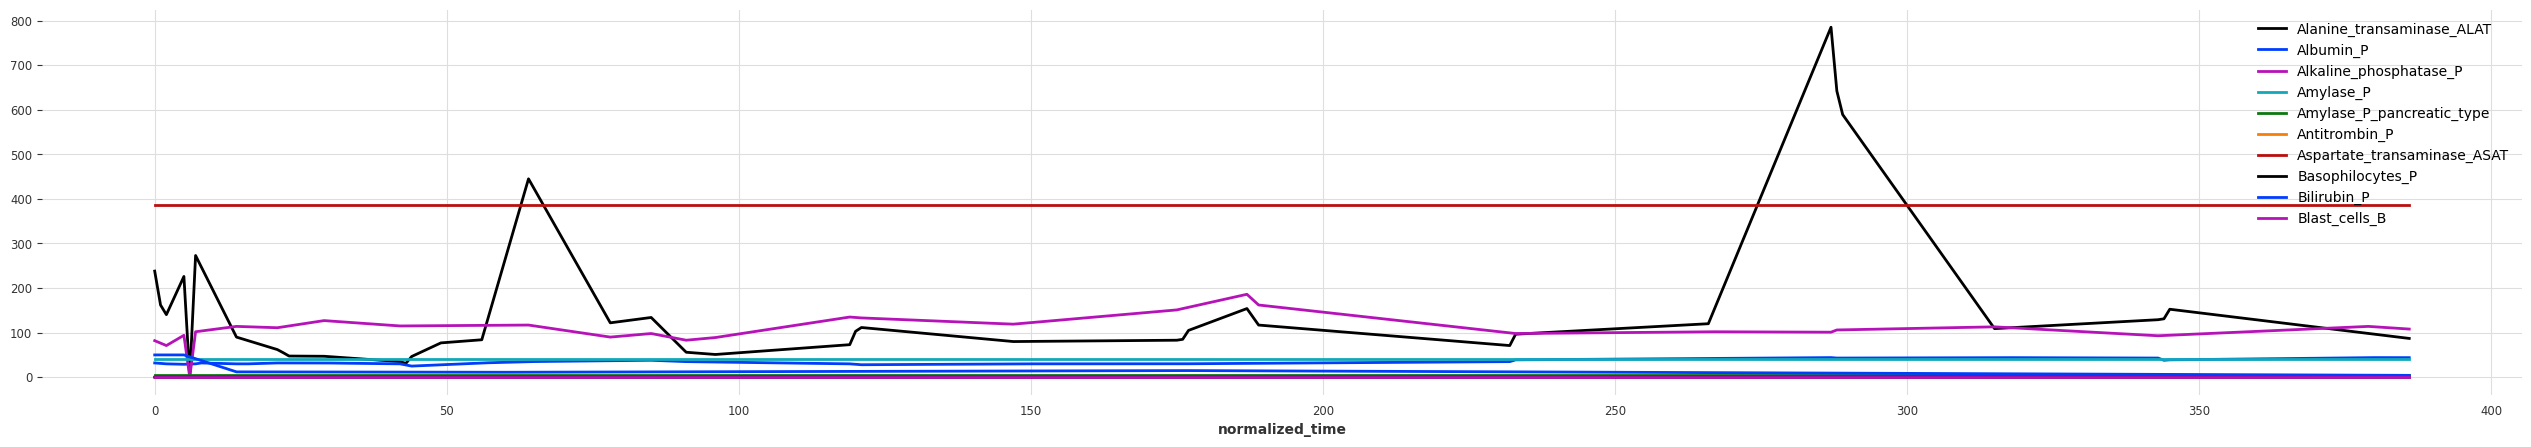

In [29]:
train_list[0].plot()

In [30]:
train_list[0].head()

<TimeSeries (DataArray) (normalized_time: 5, component: 189, sample: 1)> Size: 4kB
array([[[2.3800000e+02],
        [3.2000000e+01],
        [8.2000000e+01],
        [4.0000000e+01],
        [5.0000000e+00],
        [1.1000000e+00],
        [3.8600000e+02],
        [2.0000000e-02],
        [5.0000000e+01],
        [0.0000000e+00],
        [1.0000000e+00],
        [2.1099999e+00],
        [2.1700001e+00],
        [1.2400000e+00],
        [5.5000000e+00],
        [1.0500000e+02],
        [2.5000000e+00],
        [1.5000001e-01],
        [1.0000000e-01],
        [0.0000000e+00],
...
        [5.0000000e+00],
        [5.0000000e+00],
        [2.0000000e+00],
        [2.0000000e+00],
        [5.0000000e+00],
        [2.0000000e+00],
        [5.0000000e+00],
        [5.0000000e+00],
        [2.0000000e+00],
        [5.0000000e+00],
        [5.0000000e+00],
        [5.0000000e+00],
        [5.0000000e+00],
        [2.0000000e+00],
        [2.0000000e+00],
        [5.0000000e+00],
        [5.0000000e+00],
        [5.0000000e+00],
        [5.0000000e+00],
        [5.0000000e+00]]], dtype=float32)
Coordinates:
  * normalized_time  (normalized_time) int64 40B 0 1 2 3 4
  * component        (component) object 2kB 'Alanine_transaminase_ALAT' ... '...
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  sex  age_at_diagdate\nglobal_compo...
    hierarchy:          None

In [31]:
# Count the number of rows in each list
train_rows = sum(len(ts) for ts in train_list)
val_rows = sum(len(ts) for ts in val_list)
test_rows = sum(len(ts) for ts in test_list)

# Calculate the total number of rows
total_rows = train_rows + val_rows + test_rows

print(f"Number of rows in train_list: {train_rows}")
print(f"Number of rows in val_list: {val_rows}")
print(f"Number of rows in test_list: {test_rows}")
print(f"Total number of rows: {total_rows}")

Number of rows in train_list: 50655
Number of rows in val_list: 7143
Number of rows in test_list: 14027
Total number of rows: 71825


In [32]:
# Check the number of rows with NaN values in each column
nan_rows_per_column = processed_df.isna().sum()

# Count the total number of rows with at least one NaN value
total_nan_rows = processed_df.isna().any(axis=1).sum()

print(f"Number of rows with NaN values per column:\n{nan_rows_per_column}")
print(f"\nTotal number of rows with at least one NaN value: {total_nan_rows}")

Number of rows with NaN values per column:
unique_id                                          0
normalized_time                                    0
age_at_diagdate                                    0
sex                                                0
infno                                              0
                                                  ..
Thyrotropin_TSH_delta                              0
Triacylglycerol_lipase_delta                       0
Triglycerides_P_pt_fasting_status_unknown_delta    0
Urate_delta                                        0
eGFR_DSKB_DNS_2009_delta                           0
Length: 195, dtype: int64

Total number of rows with at least one NaN value: 0


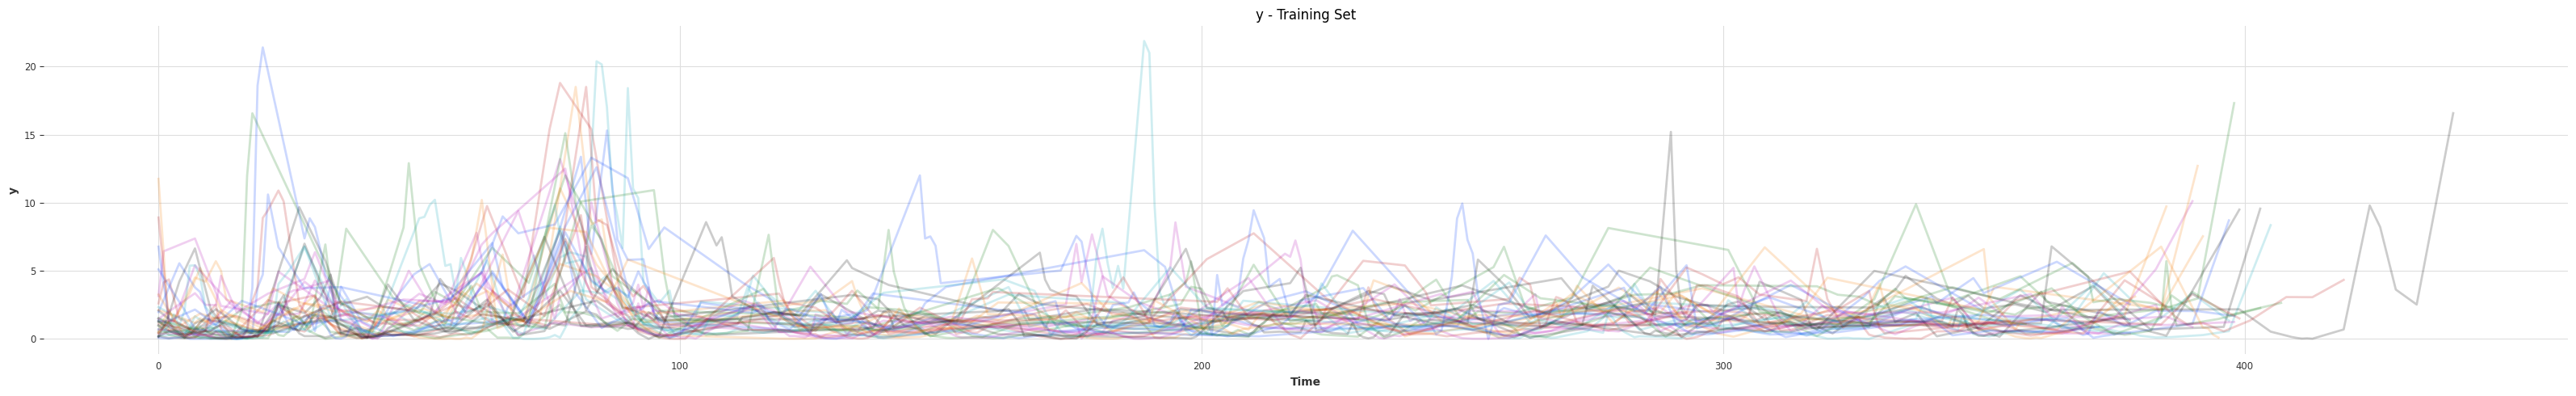

In [33]:
# Choose a component to plot
component_to_plot = "y"

# Plot the chosen component for the training set
fig, ax = plt.subplots(1, 1, figsize=fig_size)
for train_series in test_list:
    train_series[component_to_plot].plot(ax=ax, label="_nolegend_", alpha=0.2)
ax.set_xlabel("Time")
ax.set_ylabel(component_to_plot)
ax.set_title(f"{component_to_plot} - Training Set")
plt.tight_layout()
plt.show()

In [34]:
# Check the number of features and samples in each dataset
print("Training Target Width:", train_list[0].width)
print("Validation Target Width:", val_list[0].width)
print(
    "Training Covariates Width:",
    train_covariates_list[0].width if train_covariates_list else "None",
)
print(
    "Validation Covariates Width:",
    val_covariates_list[0].width if val_covariates_list else "None",
)

Training Target Width: 189
Validation Target Width: 189
Training Covariates Width: 2
Validation Covariates Width: 2


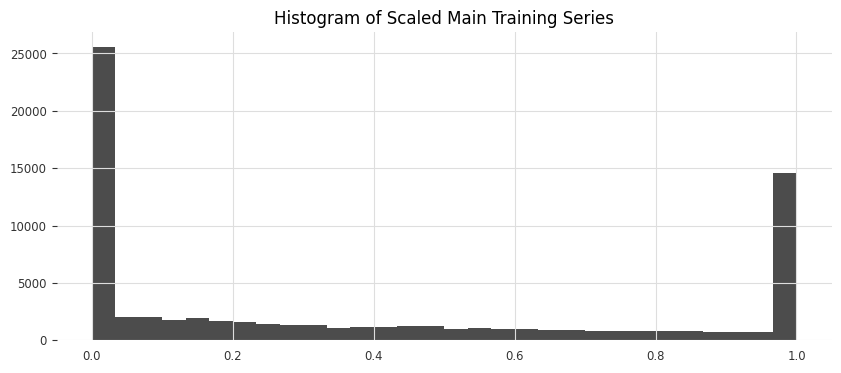

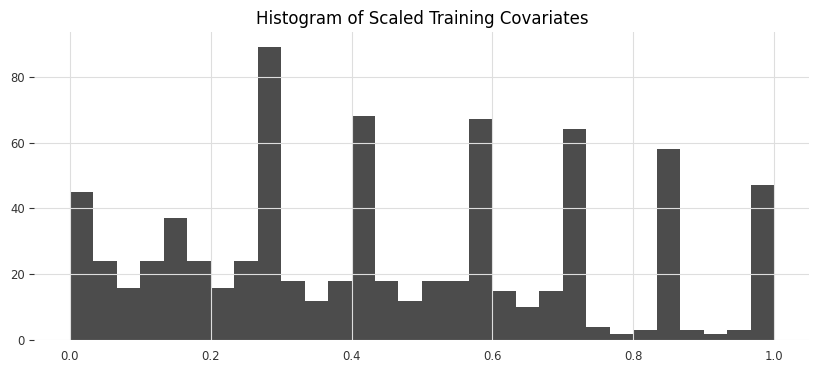

In [35]:
import matplotlib.pyplot as plt


def plot_scaled_data(series, title=""):
    plt.figure(figsize=(10, 4))
    plt.hist(series.values().flatten(), bins=30, alpha=0.7)
    plt.title(title)
    plt.grid(True)
    plt.show()


# Assuming 'train_scaled' and 'train_covariates_scaled' are lists of TimeSeries objects
plot_scaled_data(train_scaled[0], title="Histogram of Scaled Main Training Series")
plot_scaled_data(
    train_covariates_scaled[0], title="Histogram of Scaled Training Covariates"
)

In [36]:
import optuna
from darts.metrics import dtw_metric
from darts.models import TSMixerModel
from darts.utils.timeseries_generation import generate_index
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


# print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

def validate_predictions(val_list, val_preds):
    if len(val_list) != len(val_preds):
        print(f"Validation mismatch: {len(val_list)} actual vs {len(val_preds)} predictions")
        return float('inf')

    scores = []
    for i, (actual, pred) in enumerate(zip(val_list, val_preds)):
        if len(actual) == 0 or len(pred) == 0:
            print(f"Empty series at position {i}")
            continue

        if not actual.has_same_time_as(pred):
            print(f"Time index mismatch at position {i}:")
            print("Actual indices:", actual.time_index)
            print("Prediction indices:", pred.time_index)
            # Align the prediction indices with the actual indices
            pred = pred.slice_intersect(actual)

        try:
            score = mse(actual, pred)
            scores.append(score)
        except Exception as e:
            print(f"Error processing pair at index {i} with error: {str(e)}")
            print("Actual values:", actual.values())
            print("Predicted values:", pred.values())

    if scores:
        average_score = np.mean(scores)
        print("Average DTW:", average_score)
        return average_score
    else:
        print("No valid scores calculated.")
        return float('inf')

# Define the objective function for hyperparameter tuning
def objective(trial):
    # Suggest values for the hyperparameters specific to TSMixerModel
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.7, step=0.1)
    ff_size = trial.suggest_categorical("ff_size", [32, 64, 128, 256])
    optimizer_kwargs = {"lr": trial.suggest_float("lr", 0.00001, 0.002, log=True)}
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])

    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping(
        "val_loss", min_delta=0.001, patience=5, mode="min", verbose=True
    )
    callback = [pruner, early_stopper]
    # Model and trainer configurations
    pl_trainer_kwargs = {
        "max_epochs": 50,
        "accelerator": "auto",
        "callbacks": callback,
    }

    # Instantiate and fit the model using scaled data
    model = TSMixerModel(
        input_chunk_length=45,
        output_chunk_length=5,
        hidden_size=hidden_size,
        ff_size=ff_size,
        dropout=dropout,
        optimizer_kwargs=optimizer_kwargs,
        pl_trainer_kwargs=pl_trainer_kwargs,
        batch_size=batch_size,
        random_state=42
    )

    # Debugging prints for data
    def print_series_info(series_list, name):
        for i, ts in enumerate(series_list):
            print(f"{name} series {i}: n_timesteps={ts.n_timesteps}, n_components={ts.n_components}, n_samples={ts.n_samples}")

    print_series_info(train_scaled, "Train scaled")
    print_series_info(val_scaled, "Validation scaled")
    print_series_info(train_covariates_scaled, "Train covariates scaled")
    print_series_info(val_covariates_scaled, "Validation covariates scaled")

    # Inverse scaling function
    def inverse_scale(scaler, series_list):
        return [scaler.inverse_transform(ts) for ts in series_list]

    model.fit(
        series=train_scaled,  # Use scaled training data
        past_covariates=train_covariates_scaled,  # Use scaled training covariates
        val_series=val_scaled,  # Use scaled validation data
        val_past_covariates=val_covariates_scaled,
        verbose=True,
    )

    val_preds = model.predict(
        n=5,  # Ensure this matches the number of actual validation points you have
        series=val_scaled,  # Use scaled validation data
        past_covariates=val_covariates_scaled,  # Use scaled validation covariates
        verbose=True
    )

    # Inverse scale the predictions
    val_preds = inverse_scale(scaler_main, val_preds)

    # Align the predicted time series with the actual validation series
    val_preds = [pred.slice_intersect(actual) for pred, actual in zip(val_preds, val_list) if len(pred) > 0 and len(actual) > 0]

    # Now, val_preds should have the same length as val_list, and you can validate them accordingly
    average_dtw = validate_predictions(val_list, val_preds)
    print("Computed Average DTW:", average_dtw)
    return average_dtw

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

print("Number of trials:", len(study.trials))
if study.best_trial:
    print("Best trial:")
    print("  Value:", study.best_trial.value)
    print("  Params:")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")

Train scaled series 0: n_timesteps=387, n_components=189, n_samples=1
Train scaled series 1: n_timesteps=384, n_components=189, n_samples=1
Train scaled series 2: n_timesteps=392, n_components=189, n_samples=1
Train scaled series 3: n_timesteps=391, n_components=189, n_samples=1
Train scaled series 4: n_timesteps=401, n_components=189, n_samples=1
Train scaled series 5: n_timesteps=381, n_components=189, n_samples=1
Train scaled series 6: n_timesteps=397, n_components=189, n_samples=1
Train scaled series 7: n_timesteps=373, n_components=189, n_samples=1
Train scaled series 8: n_timesteps=376, n_components=189, n_samples=1
Train scaled series 9: n_timesteps=398, n_components=189, n_samples=1
Train scaled series 10: n_timesteps=419, n_components=189, n_samples=1
Train scaled series 11: n_timesteps=392, n_components=189, n_samples=1
Train scaled series 12: n_timesteps=387, n_components=189, n_samples=1
Train scaled series 13: n_timesteps=365, n_components=189, n_samples=1
Train scaled ser

In [ ]:
def custom_smape(actual: TimeSeries, forecast: TimeSeries) -> float:
    actual_values = actual.univariate_values()
    forecast_values = forecast.univariate_values()

    numerator = np.abs(forecast_values - actual_values)
    denominator = np.abs(actual_values) + np.abs(forecast_values)
    safe_denominator = np.where(
        denominator == 0, 1, denominator
    )  # prevent division by zero
    ratio = numerator / safe_denominator
    smape = 200 * np.mean(ratio)
    return smape


def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


def objective(trial):
    # Suggest values for the hyperparameters
    decoder_output_dim = trial.suggest_int("decoder_output_dim", 8, 64, step=10)
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.1, 0.7, step=0.1)
    output_chunk_shift = trial.suggest_int("output_chunk_shift", 1, 7)
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 3)
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 1, 3)
    optimizer_kwargs = {"lr": trial.suggest_float("lr", 0.00001, 0.002, log=True)}
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
    gradient_clip_val = trial.suggest_float("gradient_clip_val", 0.5, 1.0, step=0.1)

    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping(
        "val_loss", min_delta=0.001, patience=5, mode="min", verbose=True
    )
    callback = [pruner, early_stopper]

    pl_trainer_kwargs = {
        "gradient_clip_val": gradient_clip_val,
        "max_epochs": 10,
        "accelerator": "auto",
        "callbacks": callback,
    }
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
    lr_scheduler_kwargs = {"gamma": 0.999}

    common_model_args = {
        "input_chunk_length": 40,
        "output_chunk_length": 6,
        "decoder_output_dim": decoder_output_dim,
        "output_chunk_shift": output_chunk_shift,
        "num_encoder_layers": num_encoder_layers,
        "num_decoder_layers": num_decoder_layers,
        "hidden_size": hidden_size,
        "dropout": dropout,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": None,
        "save_checkpoints": True,
        "force_reset": True,
        "random_state": 42,
        "batch_size": batch_size,
    }

    # Instantiate and fit the model
    model = TiDEModel(
        **common_model_args,
        use_reversible_instance_norm=True,
        use_static_covariates=True,
    )

    # Fit the model using scaled data
    model.fit(
        series=train_scaled,  # Use scaled training data
        past_covariates=train_covariates_scaled,  # Use scaled training covariates
        val_series=val_scaled,  # Use scaled validation data
        val_past_covariates=val_covariates_scaled,  # Use scaled validation covariates
        verbose=True,
    )

    # Predict using the fitted model
    val_preds = model.predict(
        n=6,
        series=train_scaled,  # Use scaled training data for prediction alignment
        past_covariates=val_covariates_scaled,  # Use scaled validation covariates
        verbose=True,
    )

    # Apply inverse transformation to each prediction
    # val_preds_unscaled = [scaler_main.inverse_transform(pred) for pred in val_preds]
    val_preds = scaler_main.inverse_transform(val_preds)

    # Calculate SMAPE for each prediction
    scores = [custom_smape(val_list[idx], pred) for idx, pred in enumerate(val_preds)]

    # Calculate average SMAPE across all predictions
    return np.mean(scores)  # Use average SMAPE as the optimization objective


# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

print("Number of trials:", len(study.trials))
if study.best_trial:
    print("Best trial:")
    print("  Value:", study.best_trial.value)
    print("  Params:")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")